In [1]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Add, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy

import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import pydot
from tensorflow.python.client import device_lib
import pathlib
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import random
import importlib

In [2]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
train_dir = '../datasets/based_dataset/Train'
test_dir = '../datasets/based_dataset/Test'
val_dir = '../datasets/based_dataset/Valid'

In [4]:
train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Train',
                                           class_mode = 'categorical',
                                           batch_size=32,
                                           target_size=(299,299))

Found 11825 images belonging to 3 classes.


In [5]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Test' , 
                                          target_size=(299,299), 
                                            class_mode = 'categorical',
                                        shuffle=False,
                                        batch_size=32)

valid = test_data_gen.flow_from_directory(directory= '../datasets/based_dataset/Valid' , 
                                          target_size=(299,299), 
                                            class_mode = 'categorical',
                                        shuffle=False,
                                        batch_size=32)

Found 3698 images belonging to 3 classes.
Found 2956 images belonging to 3 classes.


In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model2 = InceptionV3(input_shape = (299, 299, 3), include_top = False, weights = 'imagenet')

In [7]:
for layer in base_model2.layers:
    layer.trainable = False

In [8]:
x = Flatten()(base_model2.output)
d1 = Dense(1024, activation= 'relu')(x)
dr1 = Dropout(0.3)(d1)
d2 = Dense(1024, activation= 'relu')(dr1)
dr2 = Dropout(0.3)(d2)
prediction= Dense(units=3 , activation='softmax')(dr2)

model8 = Model(base_model2.input,prediction)

In [9]:
model8.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [10]:
early = EarlyStopping(monitor='accuracy',patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy',patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [11]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.7033995966580235, 1: 1.0246079195910234, 2: 0.695915725047081}


C:\Users\amara\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [12]:
hist = model8.fit(train,
                 epochs= 50,
                 validation_data= valid,
                 class_weight=cw,
                 callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/50
370/370 [==============================] - 190s 493ms/step - loss: 3.7968 - accuracy: 0.5714 - val_loss: 0.8484 - val_accuracy: 0.6806
Epoch 2/50
370/370 [==============================] - 191s 515ms/step - loss: 0.8656 - accuracy: 0.6950 - val_loss: 0.7221 - val_accuracy: 0.7635
Epoch 3/50
370/370 [==============================] - 192s 518ms/step - loss: 0.8641 - accuracy: 0.7092 - val_loss: 0.7885 - val_accuracy: 0.7189
Epoch 4/50
370/370 [==============================] - 193s 521ms/step - loss: 0.8704 - accuracy: 0.6986 - val_loss: 0.7828 - val_accuracy: 0.7639
Epoch 5/50
370/370 [==============================] - 193s 522ms/step - loss: 0.8038 - accuracy: 0.7264 - val_loss: 0.6500 - val_accuracy: 0.8045
Epoch 6/50
370/370 [==============================] - 193s 521ms/step - loss: 0.7761 - accuracy: 0.7392 - val_loss: 0.6264 - val_acc

In [13]:
test_accu = model8.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

116/116 [==============================] - 17s 148ms/step - loss: 0.4575 - accuracy: 0.8515
The testing accuracy is : 85.15413999557495 %


In [14]:
model8.save('inceptionV3_normal_covid_lungOpacity')

INFO:tensorflow:Assets written to: inceptionV3_normal_covid_lungOpacity\assets


In [15]:
pred = model8.predict(test,verbose=1)

116/116 [==============================] - 16s 127ms/step


In [16]:
predictions = np.argmax(pred, axis = -1)

In [17]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','COVID', 'Lung Opacity']))

              precision    recall  f1-score   support

      NORMAL       0.87      0.70      0.78       724
       COVID       0.80      0.90      0.85      1203
Lung Opacity       0.88      0.88      0.88      1771

    accuracy                           0.85      3698
   macro avg       0.85      0.83      0.84      3698
weighted avg       0.85      0.85      0.85      3698



In [18]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns

<AxesSubplot:>

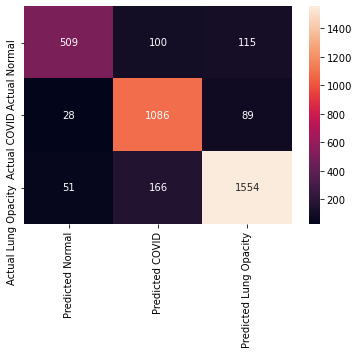

In [19]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions),index=["Actual Normal", "Actual COVID", "Actual Lung Opacity"],
columns=["Predicted Normal", "Predicted COVID","Predicted Lung Opacity"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [20]:
y_true=test.classes

**Overall Results**
Accuracy Result: 85.15%
Precision Result: 80.33%
Recall Result: 90.27%
F-Score Result: 85.01%


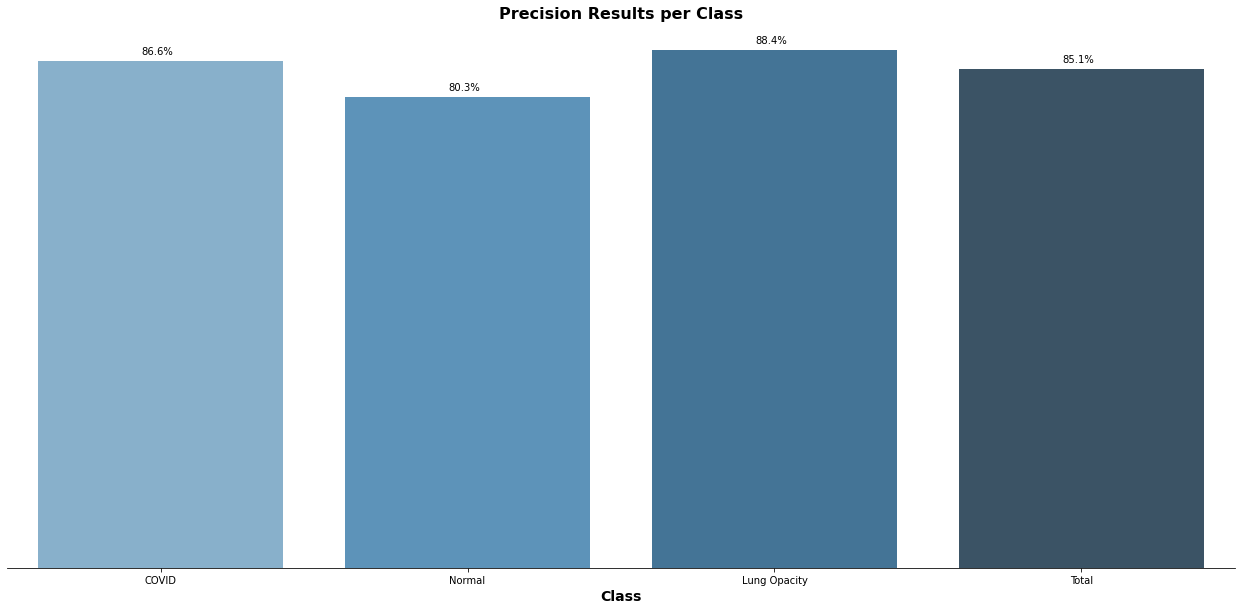

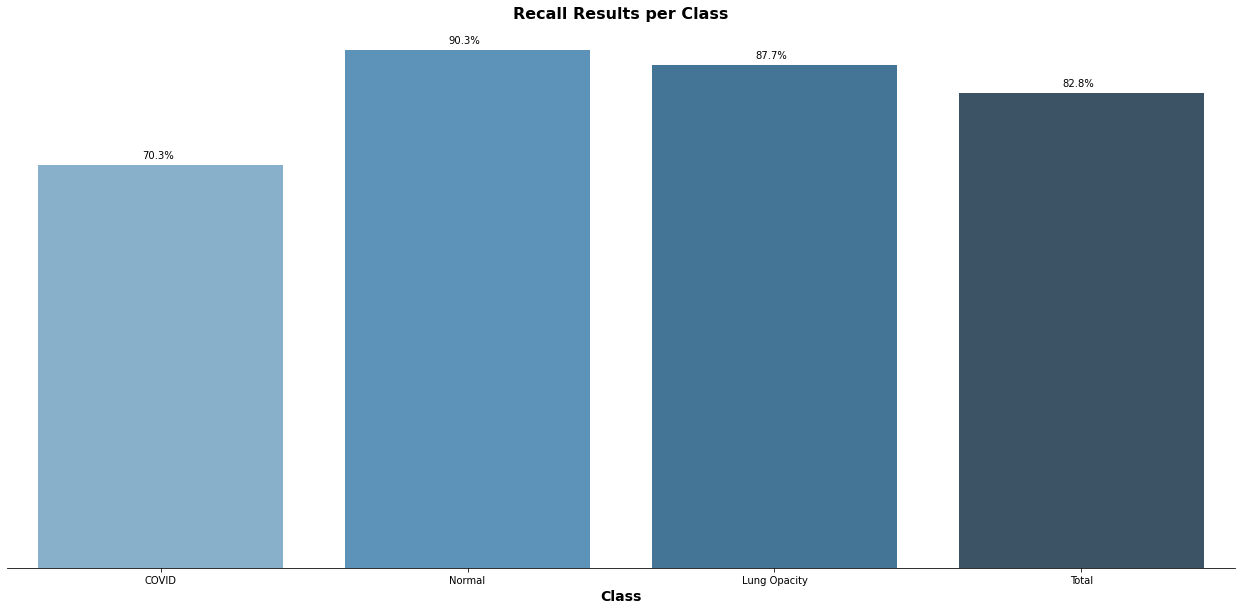

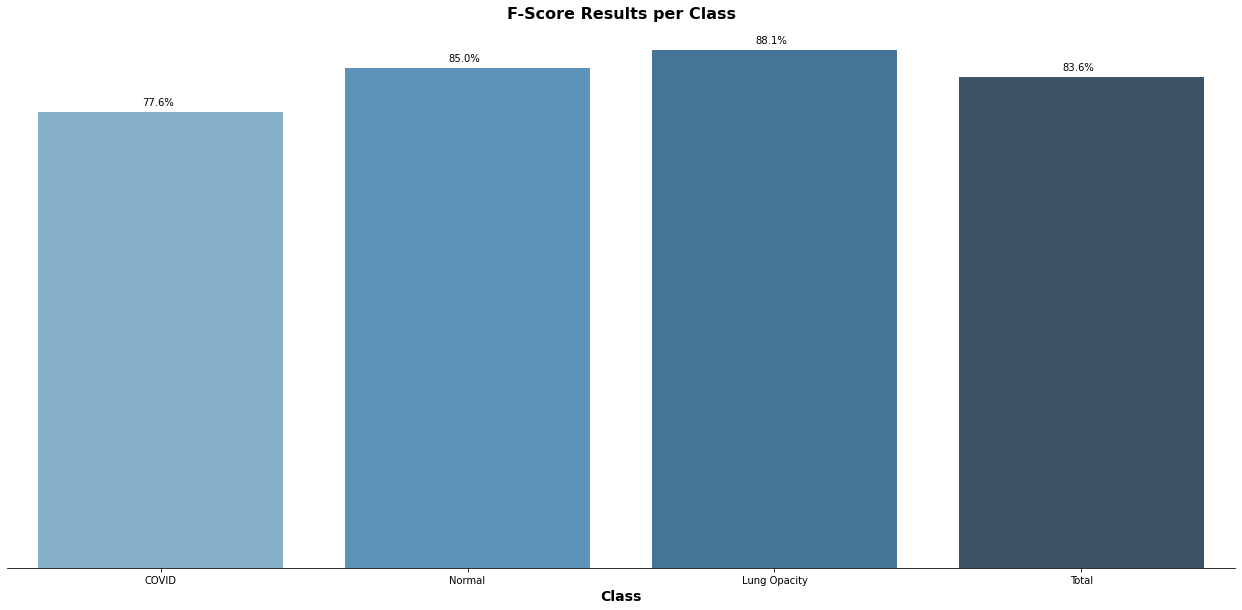

In [21]:
#Accuracy Result
acc = accuracy_score(y_true, predictions)
#Precision, Recall and F-Score (For the whole dataset)
results_all = precision_recall_fscore_support(y_true, predictions, average='macro',zero_division = 1)
#Precision, Recall and F-Score (For each Class)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division = 1)

#Organise the Results into a Dataframe
metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID','Normal','Lung Opacity','Total']

#Function to plot the metrics into a nice bar Plot
def metrics_plot(df,metric):
    plt.figure(figsize=(22,10))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');
    
metrics_plot(all_df, 'Precision')#Results by Class
metrics_plot(all_df, 'Recall')#Results by Class
metrics_plot(all_df, 'F-Score')#Results by Class
print('**Overall Results**')
print('Accuracy Result: %.2f%%'%(acc*100)) #Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[1,0]*100))#Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[1,1]*100))#Recall of the whole Dataset
print('F-Score Result: %.2f%%'%(all_df.iloc[1,2]*100))#F-Score of the whole Dataset

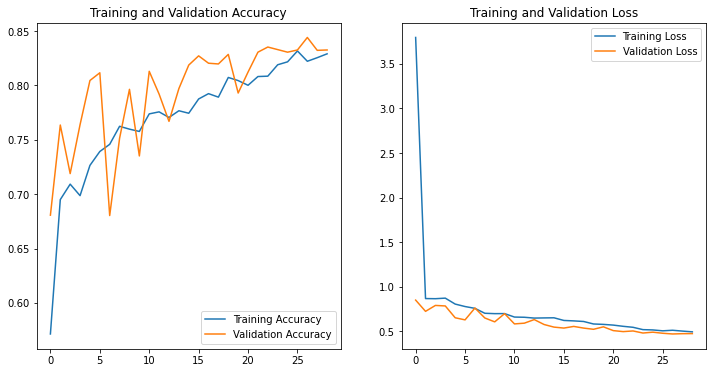

In [23]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(29)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()